In [1]:
from torch import nn as tnn


class BlockTorch(tnn.Module):

    def __init__(self, kernel_size, channles):
        super().__init__()
        self.conv1d = tnn.Conv1d(
            in_channels=channles,
            out_channels=channles,
            bias=True,
            kernel_size=kernel_size,
            groups=channles,
            padding=3,
        )

    def forward(
        self,
        x,
    ):
        batch_size, seq_len, _ = x.shape
        x = self.conv1d(x.transpose(1, 2))[..., :seq_len]
        return x.transpose(1, 2)

In [2]:
from flax import linen as nn
import jax
import jax.numpy as jnp


class BlockJAX_0(nn.Module):
  kernel_size: int
  channels: int
  kernel: jax.Array
  bias: jax.Array

  def setup(self):

    def kernel_init(key, shape, dtype):
      assert self.kernel.shape == shape
      return self.kernel.astype(dtype)
    
    def bias_init(key, shape, dtype):
      assert self.bias.shape == shape
      return self.bias.astype(dtype)

    self.conv1d = nn.Conv(features=self.channels,
                          kernel_size=[self.kernel_size],
                          feature_group_count=self.channels,
                          padding='CAUSAL',
                          use_bias=True,
                          kernel_init=kernel_init,
                          bias_init=bias_init,
                          )
    
  def __call__(self, x):
    x = self.conv1d(x)
    return x
  

class BlockJAX_1(nn.Module):
  kernel_size: int
  channels: int
  kernel: jax.Array
  bias: jax.Array

  def setup(self):

    def kernel_init(key, shape, dtype):
      assert self.kernel.shape == shape
      return self.kernel.astype(dtype)
    
    def bias_init(key, shape, dtype):
      assert self.bias.shape == shape
      return self.bias.astype(dtype)

    self.conv1d = nn.Conv(features=self.channels,
                          kernel_size=[self.kernel_size],
                          feature_group_count=self.channels,
                          padding=self.kernel_size - 1,
                          use_bias=True,
                          kernel_init=kernel_init,
                          bias_init=bias_init,
                          )
    
  def __call__(self, x):
    (b, l, d) = x.shape
    x = self.conv1d(x)[:, :l, :]
    return x

In [16]:
kernel_size = 4
channels = 2048

batch_size = 4
length = 4096

In [17]:
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
rs = RandomState(MT19937(SeedSequence(123456789)))

# prepare common weights and inputs
kernel = rs.normal(size=(kernel_size, 1, channels))
bias = rs.normal(size=(channels,))
input = rs.normal(size=(batch_size, length, channels))
grads_GT = np.array([[input[:, :-3, :].mean(axis=(0, 1))], [input[:, :-2, :].mean(axis=(0, 1))], [input[:, :-1, :].mean(axis=(0, 1))], [input[:, :, :].mean(axis=(0, 1))]])


In [18]:
import torch

# torch module forward and backward
torch.set_printoptions(precision=7)
conv_torch = BlockTorch(kernel_size, channels)
conv_torch.to(torch.bfloat16)
state_dict = conv_torch.state_dict()
state_dict["conv1d.weight"] = torch.from_numpy(kernel).to(torch.bfloat16).transpose(0, 2)
state_dict["conv1d.bias"] = torch.from_numpy(bias).to(torch.bfloat16)
conv_torch.load_state_dict(state_dict)
conv_torch.zero_grad()
output_torch = conv_torch(torch.from_numpy(input).to(torch.bfloat16))
loss_torch = output_torch.mean() * channels
loss_torch.backward()

loss_torch = loss_torch.detach().float().numpy()
output_torch = output_torch.detach().float().numpy()
grad_torch = conv_torch.conv1d.weight.grad.T.detach().float().numpy()

In [19]:
import jax
import jax.numpy as jnp

#jax.config.update('jax_default_device', jax.devices('cpu')[0])

# flax module forward and backward
def jax_forward_backward(model, params, input):
  def forward(params, input):
    output = model.apply(params, input)
    loss = jnp.mean(output) * channels
    return loss, output

  forward_backward_fn = jax.value_and_grad(forward, has_aux=True)
  (loss, output), grad = forward_backward_fn(params, input)
  return loss, output, grad

input_jax = jnp.array(input)
kernel_jax = jnp.array(kernel)
bias_jax = jnp.array(bias)

conv_jax_0 = BlockJAX_0(kernel_size, channels, kernel_jax, bias_jax)
rng = jax.random.key(0)
params_jax_0 = conv_jax_0.init(rng, input_jax)
loss_jax_0, output_jax_0, grad_jax_0 = jax_forward_backward(conv_jax_0, params_jax_0, input_jax)

loss_jax_0 = np.array(loss_jax_0)
output_jax_0 = np.array(output_jax_0)
grad_jax_0 = np.array(grad_jax_0["params"]["conv1d"]["kernel"])

conv_jax_1 = BlockJAX_1(kernel_size, channels, kernel_jax, bias_jax)
params_jax_1 = conv_jax_1.init(rng, input_jax)
loss_jax_1, output_jax_1, grad_jax_1 = jax_forward_backward(conv_jax_1, params_jax_1, input_jax)

loss_jax_1 = np.array(loss_jax_1)
output_jax_1 = np.array(output_jax_1)
grad_jax_1 = np.array(grad_jax_1["params"]["conv1d"]["kernel"])

In [20]:
print("================================================")
print(f"grad_GT: {grads_GT.shape}")
print(grads_GT)
print("================================================")
print(f"conv_torch.conv1d.weight.grad.T shape: {grad_torch.shape}")
print(grad_torch)
print("================================================")
print(f'grad_jax_0["params"]["conv1d"]["kernel"] {grad_jax_0.shape}')
print(grad_jax_0)
print("================================================")

grad_GT: (4, 1, 2048)
[[[ 7.43292193e-03  3.69220792e-02  2.25807118e-02 ...  6.51079576e-04
    2.22195747e-02 -8.49548186e-03]]

 [[ 6.80273620e-03  3.67347524e-02  2.34057249e-02 ...  1.09565400e-03
    2.14861925e-02 -8.81613825e-03]]

 [[ 6.32915366e-03  3.63664825e-02  2.48282140e-02 ...  6.66045551e-05
    2.08543784e-02 -8.60816403e-03]]

 [[ 6.01445782e-03  3.61876409e-02  2.39811962e-02 ...  4.71404915e-04
    2.06272668e-02 -8.68662285e-03]]]
conv_torch.conv1d.weight.grad.T shape: (4, 1, 2048)
[[[ 7.4157715e-03  3.6865234e-02  2.2460938e-02 ...  6.4086914e-04
    2.2094727e-02 -8.4228516e-03]]

 [[ 6.8054199e-03  3.6621094e-02  2.3315430e-02 ...  1.0833740e-03
    2.1484375e-02 -8.7890625e-03]]

 [[ 6.3171387e-03  3.6376953e-02  2.4780273e-02 ...  5.7935715e-05
    2.0874023e-02 -8.5449219e-03]]

 [[ 6.0119629e-03  3.6132812e-02  2.3925781e-02 ...  4.6157837e-04
    2.0629883e-02 -8.6669922e-03]]]
grad_jax_0["params"]["conv1d"]["kernel"] (4, 1, 2048)
[[[ 7.4111456e-03  3.681

In [21]:
def wmape(a, b):
  return np.sum(np.abs(a - b)) / np.sum(np.abs(a))

print(f"losses: {(loss_torch, loss_jax_0, loss_jax_1)}")

print("Outputs WMAPE:")
print(wmape(output_torch, output_jax_0))
print(wmape(output_torch, output_jax_1))

print("Grads WMAPE:")
print(wmape(grads_GT, grad_torch))
print(wmape(grads_GT, grad_jax_0))
print(wmape(grads_GT, grad_jax_1))

losses: (array(-56.5, dtype=float32), array(-56.4777, dtype=float32), array(-56.4777, dtype=float32))
Outputs WMAPE:
0.0021535417
0.0021535417
Grads WMAPE:
0.002786071489077457
0.001465496766552481
0.7320775894659343


In [22]:
def plot_error(a, b):
  import matplotlib.pyplot as plt
  e = np.mean(np.abs(a - b), axis=(0, 1)) / np.mean(np.abs(a))  # per-channel mean abs error normalized on the mean abs of a
  x = np.arange(channels)
  fig, ax = plt.subplots()
  ax.plot(x, e, '.', markeredgewidth=2)
  plt.show()

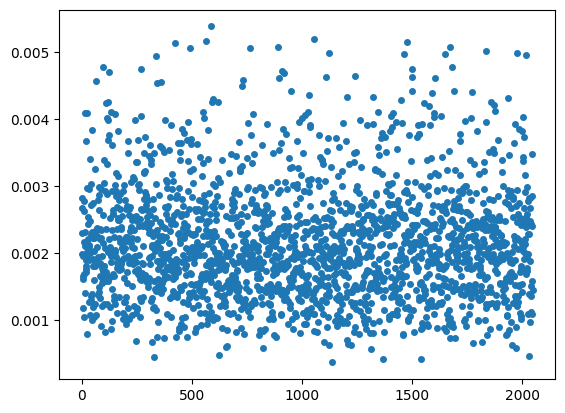

In [23]:
plot_error(output_torch, output_jax_0)

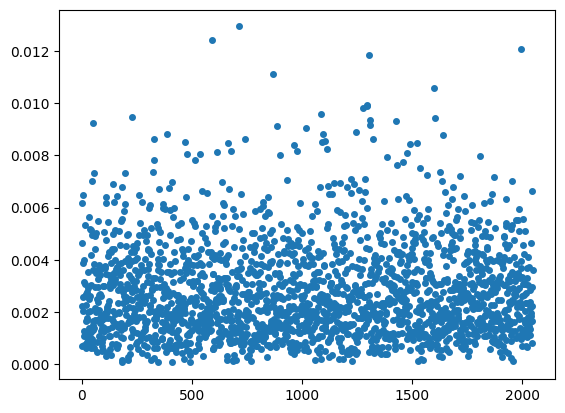

In [24]:
plot_error(grads_GT, grad_torch)

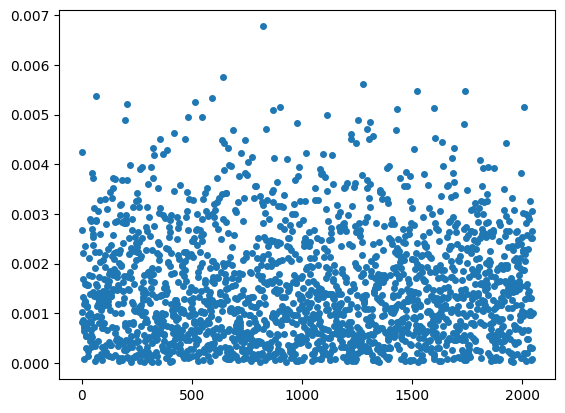

In [25]:
plot_error(grads_GT, grad_jax_0)

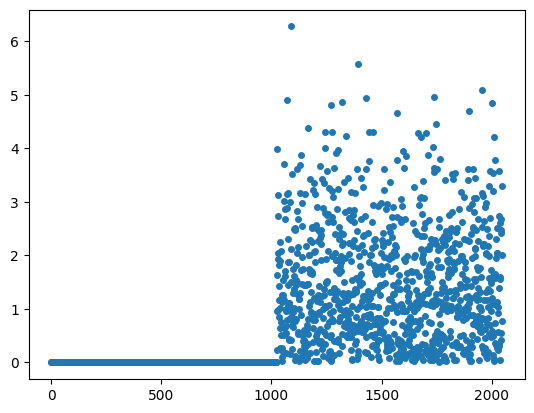

In [26]:
plot_error(grads_GT, grad_jax_1)